In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [2]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

# Generator

In [5]:
base_path = '/kaggle/input/pe-2-main-dataset/combined-real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)




Found 100000 images belonging to 2 classes.


In [6]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.


# Train Model DenseNet   

In [8]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [11]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit(
    train_flow,
    epochs = 10,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1383s 785ms/step - accuracy: 0.6313 - loss: 0.6394 - val_accuracy: 0.5141 - val_loss: 1.6835
Epoch 2/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 17:31 674ms/step - accuracy: 0.8125 - loss: 0.3935

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8125 - loss: 0.3935 - val_accuracy: 0.5625 - val_loss: 1.4708
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1081s 691ms/step - accuracy: 0.8371 - loss: 0.3707 - val_accuracy: 0.7744 - val_loss: 0.5403
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 68us/step - accuracy: 0.9219 - loss: 0.1605 - val_accuracy: 0.7500 - val_loss: 0.7295
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1090s 697ms/step - accuracy: 0.9172 - loss: 0.2039 - val_accuracy: 0.8140 - val_loss: 0.4745
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 68us/step - accuracy: 0.9062 - loss: 0.2140 - val_accuracy: 0.6562 - val_loss: 0.6946
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1093s 699ms/step - accuracy: 0.9538 - loss: 0.1216 - val_accuracy: 0.8990 - val_loss: 0.2580
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 71us/step - accuracy: 0.9688 - loss: 0.0931 - val_accuracy: 0.9062 - val_loss: 0.3110
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1098s 702ms/step - accuracy: 0.9689 - los

# Evaluation

In [20]:
model.save('completed_trained_model.h5')

In [15]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

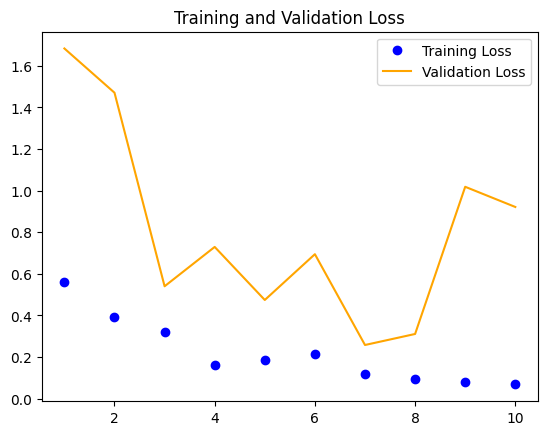

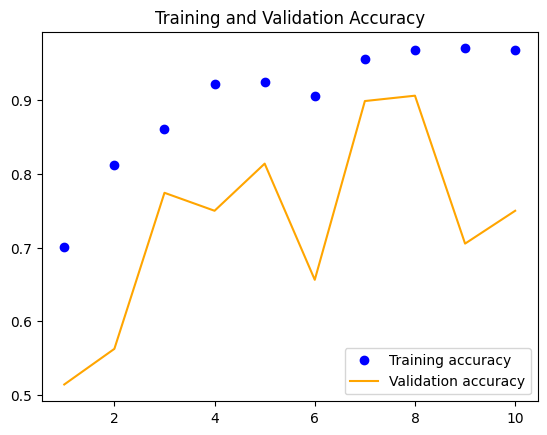

In [17]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [18]:
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred = model.predict(test_flow)
y_test = test_flow.classes

Found 22041 images belonging to 2 classes.
22041/22041 ━━━━━━━━━━━━━━━━━━━━ 242s 11ms/step


In [19]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.9024257796109209
AP Score: 0.8517697410219167

              precision    recall  f1-score   support

           0       1.00      0.38      0.55     10960
           1       0.62      1.00      0.77     11081

    accuracy                           0.69     22041
   macro avg       0.81      0.69      0.66     22041
weighted avg       0.81      0.69      0.66     22041



In [22]:
!ls /kaggle/working/

completed_trained_model.h5


In [23]:
!zip model.zip /kaggle/working/completed_trained_model.h5
from IPython.display import FileLink
FileLink('model.zip')  # Click to download

  adding: kaggle/working/completed_trained_model.h5 (deflated 9%)


/kaggle/working/model.zip